In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.experiment.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - '06_27_24_OCTA_6M_Lab100_Analysis'
        # - '06_27_24_OCTA_6M_Lab255_Analysis'

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 32032 -> 31936 rows.
Finished loading inference stats.
Log amounts: root                                                                    log_set                                              
/storage/vbutoi/scratch/ESE/inference/06_27_24_OCTA_6M_Lab100_Analysis  20240627_151001-IDRP-8fe26c6cee0fab95e0f779b99ae99d9f    1089
                                                                        20240627_151006-W32V-bef6127a545bdedb17fdfb3b1f02d129    1089
                                                                        20240627_151010-L0EA-cd7d455b3805b49b17af39d14a81042a    1089
                                                                        20240627_151015-UYZ4-3d09c113ada95de95137a49d3eff11ec    1089
                                                                        20240627_151019-LFX3-4abd7901a2152b2eeb38c274cb819dda    1089
                                                                 

In [4]:
def loss_func(loss_func_class):
    if loss_func_class == "None":
        return 'Combo'
    else:
        return loss_func_class.split('.')[-1]

inference_df.augment(loss_func)

In [5]:
inference_df['label'].unique()

array([100])

In [6]:
# For the purpose of this experiment, we only care about a few columns in particular:
exp_columns = [
    "data_id",
    "loss_func",
    "new_gt_proportion", # This is after our resizing and blurring
    "gt_proportion",
    "soft_proportion",
    "hard_proportion",
    "pretrained_seed", 
    "pretrained_exp_root",
    "split",
]
# Take these columns of the inference_df, drop other columns.
total_exp_df = inference_df[exp_columns].drop_duplicates().reset_index(drop=True)

# Remove rows corresponding to pretrained seed 42, it crashed.
exp_df = total_exp_df[total_exp_df.pretrained_seed != 42].reset_index(drop=True)
# We only want to focus on a single label for the proportion.
# exp_df = pruned_exp_df[pruned_exp_df.label == 100].reset_index(drop=True)
# exp_df = pruned_exp_df[pruned_exp_df.label == 255].reset_index(drop=True)

In [7]:
# Get number of examples we are evaluating on.
len(exp_df['data_id'].unique())

91

In [8]:
# We need to rename 'proportion' to 'proportion' for the sake of the experiment.
proportion_df = exp_df.rename(columns={
    "gt_proportion": "gt proportion",
    "new_gt_proportion": "new gt proportion",
    "hard_proportion": "hard proportion",
    "soft_proportion": "soft proportion",
})

In [9]:
# Make two new columns, one for the soft proportion error and one for the hard proportion error.
proportion_df['new gt error'] = (proportion_df['new gt proportion'] - proportion_df['gt proportion'])
proportion_df['soft error'] = (proportion_df['soft proportion'] - proportion_df['gt proportion'])
proportion_df['hard error'] = (proportion_df['hard proportion'] - proportion_df['gt proportion'])
# Make the normalized metric that divides the error by the ground truth proportion.
proportion_df['new gt relative error'] = proportion_df['new gt error'] / proportion_df['gt proportion']
proportion_df['soft relative error'] = proportion_df['soft error'] / proportion_df['gt proportion']
proportion_df['hard relative error'] = proportion_df['hard error'] / proportion_df['gt proportion']

In [10]:
proportion_df

,data_id,loss_func,new gt proportion,gt proportion,soft proportion,hard proportion,pretrained_seed,pretrained_exp_root,split,new gt error,soft error,hard error,new gt relative error,soft relative error,hard relative error
0,subject_10233.bmp,SoftDiceLoss,0.009888,0.009850,0.012801,0.012085,40,/storage/vbutoi/scratch/ESE/training/06_27_24_...,val,0.000038,0.002951,0.002235,0.003827,0.299635,0.226900
1,subject_10128.bmp,SoftDiceLoss,0.005249,0.005244,0.008376,0.007751,40,/storage/vbutoi/scratch/ESE/training/06_27_24_...,val,0.000005,0.003132,0.002508,0.001006,0.597295,0.478229
2,subject_10097.bmp,SoftDiceLoss,0.008423,0.008412,0.012797,0.012207,40,/storage/vbutoi/scratch/ESE/training/06_27_24_...,val,0.000010,0.004385,0.003795,0.001230,0.521239,0.451059
3,subject_10066.bmp,SoftDiceLoss,0.008240,0.008537,0.010472,0.009949,40,/storage/vbutoi/scratch/ESE/training/06_27_24_...,val,-0.000298,0.001934,0.001411,-0.034876,0.226578,0.165298
4,subject_10111.bmp,SoftDiceLoss,0.010193,0.010387,0.015802,0.014954,40,/storage/vbutoi/scratch/ESE/training/06_27_24_...,val,-0.000195,0.005415,0.004566,-0.018737,0.521285,0.439578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543,subject_10295.bmp,PixelCELoss,0.011536,0.011469,0.014020,0.012817,40,/storage/vbutoi/scratch/ESE/training/06_27_24_...,cal,0.000067,0.002552,0.001349,0.005833,0.222476,0.117592
2544,subject_10051.bmp,PixelCELoss,0.011047,0.011163,0.012385,0.011292,40,/storage/vbutoi/scratch/ESE/training/06_27_24_...,cal,-0.000115,0.001222,0.000129,-0.010315,0.109501,0.011557
2545,subject_10159.bmp,PixelCELoss,0.014587,0.014325,0.012036,0.011169,40,/storage/vbutoi/scratch/ESE/training/06_27_24_...,cal,0.000262,-0.002289,-0.003156,0.018318,-0.159774,-0.220284
2546,subject_10096.bmp,PixelCELoss,0.008606,0.008587,0.010905,0.009827,40,/storage/vbutoi/scratch/ESE/training/06_27_24_...,cal,0.000018,0.002318,0.001239,0.002149,0.269912,0.144298


In [11]:
# Important for this experiment that we only consider the 'val' and 'cal' splits because we trained on the 'train' split.
proportion_df['split'].unique()

array(['val', 'cal'], dtype=object)

# Library Funcs

In [12]:
def prepare_error_df(raw_df, groupby_keys, value_vars, var_name, value_name):
    # Make a clone of the proportion df.
    input_df = raw_df.copy()
    # Melt the dataframe to have a single column for the error.
    error_df = pd.melt(
        input_df,
        id_vars=groupby_keys,
        value_vars=value_vars,
        var_name=var_name,
        value_name=value_name,
    )
    # Make some columns that are useful for plotting.
    error_df[f'absolute {value_name}'] = error_df[value_name].abs()
    # Return the melted dataframe.
    return error_df


def calibrator(pretrained_exp_root):
    if "SVLS" in pretrained_exp_root:
        return "SVLS"
    else:
        return "Uncalibrated"


def process_method_names(input_df, value_name):
    # Make a clone of the input_df
    df = input_df.copy()
    # Drop all the rows where calibrator != Uncalibrated AND the proportion_type is hard_proportion_error.
    df = df[~((df['calibrator'] != 'Uncalibrated') & (df['proportion_type'] == f'hard {value_name}'))]
    # Then we augment the proportion_type with the calibrator name.
    def proportion_type(calibrator, loss_func, proportion_type):
        if proportion_type in ["new gt error", "new gt relative error"]:
            return "New GT"
        elif calibrator == "Uncalibrated":
            return "Uncalibrated " + proportion_type.split(" ")[0] + f" ({loss_func})"
        else:
            return calibrator + " soft" + f" ({loss_func})"
    # Finally, sort by data_id
    df['proportion type'] = df.apply(lambda x: proportion_type(x['calibrator'], x['loss_func'], x['proportion_type']), axis=1)
    df = df.sort_values(by="data_id")
    # Drop the duplicate rows and reset the index.
    df = df.drop_duplicates().reset_index(drop=True)
    # Return the augmented dataframe.
    return df

# First, let's look at absolute error.

In [13]:
proportion_df.augment(calibrator)
# Make some columns that are useful for plotting.
raw_melted_error_df = prepare_error_df(
    proportion_df, 
    groupby_keys=[
        "calibrator",
        "loss_func",
        "data_id", 
        "pretrained_seed", 
        "gt proportion", 
        "new gt proportion",
        "soft proportion", 
        "hard proportion",
        "split",
    ],
    value_vars=["new gt error", "soft error", "hard error"],
    var_name="proportion_type",
    value_name="error"
)
# Process the proportion types.
melted_error_df = process_method_names(raw_melted_error_df, value_name="error")

In [14]:
melted_error_df

,calibrator,loss_func,data_id,pretrained_seed,gt proportion,new gt proportion,soft proportion,hard proportion,split,proportion_type,error,absolute error,proportion type
0,Uncalibrated,SoftDiceLoss,subject_10003.bmp,44,0.006112,0.00592,0.013784,0.012329,val,hard error,0.006217,0.006217,Uncalibrated hard (SoftDiceLoss)
1,Uncalibrated,SoftDiceLoss,subject_10003.bmp,40,0.006112,0.00592,0.016901,0.015137,val,new gt error,-0.000192,0.000192,New GT
2,Uncalibrated,SoftDiceLoss,subject_10003.bmp,47,0.006112,0.00592,0.011416,0.010193,val,soft error,0.005304,0.005304,Uncalibrated soft (SoftDiceLoss)
3,Uncalibrated,SoftDiceLoss,subject_10003.bmp,41,0.006112,0.00592,0.017365,0.015015,val,hard error,0.008902,0.008902,Uncalibrated hard (SoftDiceLoss)
4,Uncalibrated,PixelCELoss,subject_10003.bmp,44,0.006112,0.00592,0.011561,0.010620,val,soft error,0.005448,0.005448,Uncalibrated soft (PixelCELoss)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6365,Uncalibrated,PixelCELoss,subject_10298.bmp,45,0.010750,0.01062,0.012317,0.011536,val,new gt error,-0.000130,0.000130,New GT
6366,SVLS,PixelCELoss,subject_10298.bmp,40,0.010750,0.01062,0.013031,0.011108,val,soft error,0.002281,0.002281,SVLS soft (PixelCELoss)
6367,SVLS,SoftDiceLoss,subject_10298.bmp,47,0.010750,0.01062,0.010876,0.009888,val,soft error,0.000126,0.000126,SVLS soft (SoftDiceLoss)
6368,SVLS,PixelCELoss,subject_10298.bmp,41,0.010750,0.01062,0.013221,0.012634,val,soft error,0.002471,0.002471,SVLS soft (PixelCELoss)


In [15]:
melted_error_df['proportion type'].unique()

array(['Uncalibrated hard (SoftDiceLoss)', 'New GT',
       'Uncalibrated soft (SoftDiceLoss)',
       'Uncalibrated soft (PixelCELoss)', 'SVLS soft (PixelCELoss)',
       'SVLS soft (SoftDiceLoss)', 'Uncalibrated hard (PixelCELoss)'],
      dtype=object)

In [16]:
# Finally, we want to change the order that the methods appear in.
melted_error_df['proportion type'] = melted_error_df['proportion type'].astype('category')
melted_error_df['proportion type'] = melted_error_df['proportion type'].cat.reorder_categories([
    'New GT',
    'Uncalibrated hard (PixelCELoss)',
    'Uncalibrated soft (PixelCELoss)',
    'Uncalibrated hard (SoftDiceLoss)',
    'Uncalibrated soft (SoftDiceLoss)',
    'SVLS soft (PixelCELoss)',
    'SVLS soft (SoftDiceLoss)',
])

# Custom palette dictionary
custom_palette = {
    'New GT': 'red',
    'Uncalibrated hard (PixelCELoss)': 'blue',
    'Uncalibrated soft (PixelCELoss)': 'royalblue',
    'Uncalibrated hard (SoftDiceLoss)': 'darkgreen',
    'Uncalibrated soft (SoftDiceLoss)': 'mediumseagreen',
    'SVLS soft (PixelCELoss)': 'goldenrod',
    'SVLS soft (SoftDiceLoss)': 'gold',
}

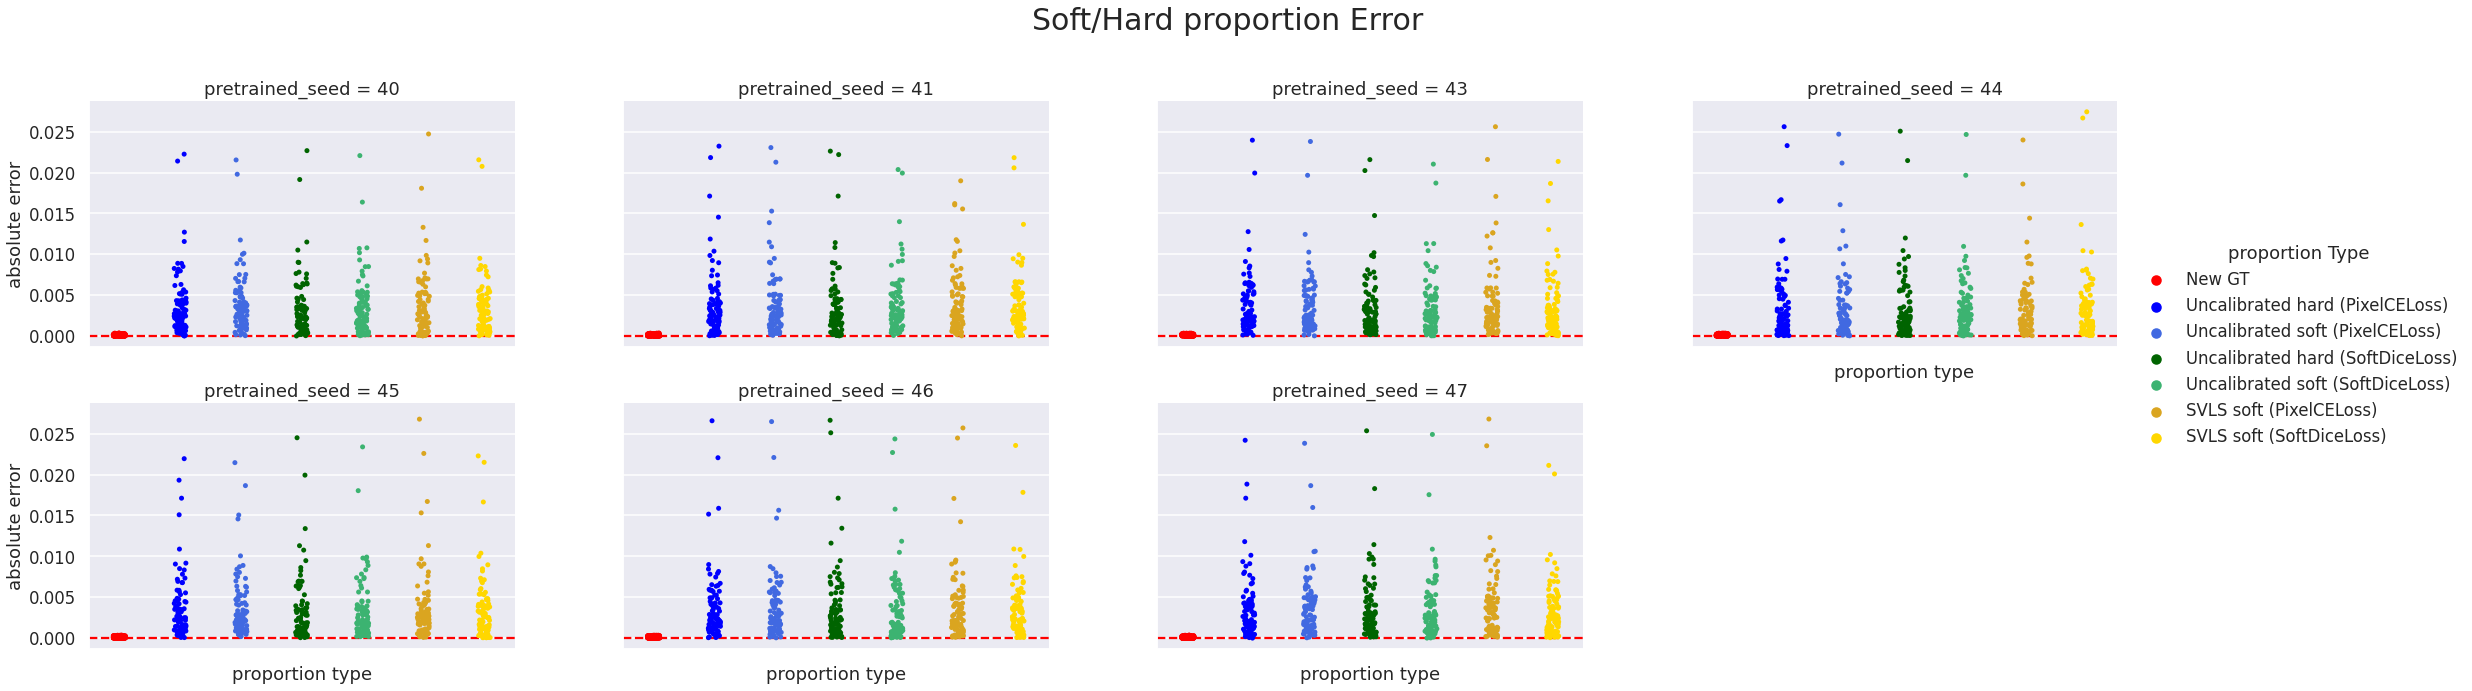

In [17]:
# Create the catplot
g = sns.catplot(
    data=melted_error_df,      # Ensure you use the 'data' parameter correctly.
    x="proportion type",
    y="absolute error",
    col="pretrained_seed",
    hue="proportion type",
    col_wrap=4,
    sharex=False,
    aspect=1.5,
    palette=custom_palette
)

# For each subplot, add a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')
    ax.set_xticklabels([])

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Soft/Hard proportion Error', fontsize=30)

# Add a legend
g.add_legend(title='proportion Type')

# Show the plot
plt.show()

In [18]:
melted_error_df

,calibrator,loss_func,data_id,pretrained_seed,gt proportion,new gt proportion,soft proportion,hard proportion,split,proportion_type,error,absolute error,proportion type
0,Uncalibrated,SoftDiceLoss,subject_10003.bmp,44,0.006112,0.00592,0.013784,0.012329,val,hard error,0.006217,0.006217,Uncalibrated hard (SoftDiceLoss)
1,Uncalibrated,SoftDiceLoss,subject_10003.bmp,40,0.006112,0.00592,0.016901,0.015137,val,new gt error,-0.000192,0.000192,New GT
2,Uncalibrated,SoftDiceLoss,subject_10003.bmp,47,0.006112,0.00592,0.011416,0.010193,val,soft error,0.005304,0.005304,Uncalibrated soft (SoftDiceLoss)
3,Uncalibrated,SoftDiceLoss,subject_10003.bmp,41,0.006112,0.00592,0.017365,0.015015,val,hard error,0.008902,0.008902,Uncalibrated hard (SoftDiceLoss)
4,Uncalibrated,PixelCELoss,subject_10003.bmp,44,0.006112,0.00592,0.011561,0.010620,val,soft error,0.005448,0.005448,Uncalibrated soft (PixelCELoss)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6365,Uncalibrated,PixelCELoss,subject_10298.bmp,45,0.010750,0.01062,0.012317,0.011536,val,new gt error,-0.000130,0.000130,New GT
6366,SVLS,PixelCELoss,subject_10298.bmp,40,0.010750,0.01062,0.013031,0.011108,val,soft error,0.002281,0.002281,SVLS soft (PixelCELoss)
6367,SVLS,SoftDiceLoss,subject_10298.bmp,47,0.010750,0.01062,0.010876,0.009888,val,soft error,0.000126,0.000126,SVLS soft (SoftDiceLoss)
6368,SVLS,PixelCELoss,subject_10298.bmp,41,0.010750,0.01062,0.013221,0.012634,val,soft error,0.002471,0.002471,SVLS soft (PixelCELoss)


In [19]:
# We want to calculate now the average (across seeds) of the the absolute error for each method.
# That means first averaging within each seed, then averaging across seeds.
# We group by the data_id and the proportion_type.
error_per_seed = melted_error_df.groupby(["pretrained_seed", "proportion type"]).agg(
    abs_error=("absolute error", "mean"),
).reset_index()
# Rename abs_error to absolute error.
error_per_seed = error_per_seed.rename(columns={"abs_error": "absolute error"})

In [20]:
# make a table with each row being the proportion type, and the column being the abs_error mean with standard deviation in another column.
method_error_table = error_per_seed.pivot_table(
    values="absolute error",
    index="proportion type",
    columns="pretrained_seed",
    aggfunc="mean",
)
# Average across the pretrained seeds to make an average column, and then make a stdv column.
method_error_table['mean'] = method_error_table.mean(axis=1)
method_error_table['stdv'] = method_error_table.std(axis=1)
# We can drop all other columns that aren't mean and stdv
method_error_table = method_error_table[['mean', 'stdv']]

In [21]:
method_error_table.sort_values(by='mean')

pretrained_seed,mean,stdv
proportion type,,
New GT,0.000112,1.355253e-20
Uncalibrated hard (SoftDiceLoss),0.003414,1.112175e-04
Uncalibrated soft (SoftDiceLoss),0.003492,2.012613e-04
SVLS soft (SoftDiceLoss),0.003586,1.533762e-04
Uncalibrated hard (PixelCELoss),0.003720,6.821237e-05
Uncalibrated soft (PixelCELoss),0.003761,1.585219e-04
SVLS soft (PixelCELoss),0.003810,2.163476e-04


## Second, let's look at relative error.

In [22]:
proportion_df.augment(calibrator)
# Make some columns that are useful for plotting.
raw_melted_relative_df = prepare_error_df(
    proportion_df, 
    groupby_keys=[
        "calibrator",
        "loss_func",
        "data_id", 
        "pretrained_seed", 
        "gt proportion", 
        "new gt proportion",
        "soft proportion", 
        "hard proportion",
        "split",
    ],
    value_vars=["new gt relative error", "soft relative error", "hard relative error"],
    var_name="proportion_type",
    value_name="relative error"
)
# Process the proportion types.
melted_relative_df = process_method_names(raw_melted_relative_df, value_name="relative error")

In [23]:
melted_relative_df['proportion type'].unique()

array(['Uncalibrated hard (SoftDiceLoss)', 'New GT',
       'Uncalibrated soft (SoftDiceLoss)',
       'Uncalibrated soft (PixelCELoss)', 'SVLS soft (PixelCELoss)',
       'SVLS soft (SoftDiceLoss)', 'Uncalibrated hard (PixelCELoss)'],
      dtype=object)

In [24]:
# Finally, we want to change the order that the methods appear in.
melted_relative_df['proportion type'] = melted_relative_df['proportion type'].astype('category')
melted_relative_df['proportion type'] = melted_relative_df['proportion type'].cat.reorder_categories([
    'New GT',
    'Uncalibrated hard (PixelCELoss)',
    'Uncalibrated soft (PixelCELoss)',
    'Uncalibrated hard (SoftDiceLoss)',
    'Uncalibrated soft (SoftDiceLoss)',
    'SVLS soft (PixelCELoss)',
    'SVLS soft (SoftDiceLoss)'
])
# Custom palette dictionary
custom_palette = {
    'New GT': 'red',
    'Uncalibrated hard (PixelCELoss)': 'blue',
    'Uncalibrated soft (PixelCELoss)': 'royalblue',
    'Uncalibrated hard (SoftDiceLoss)': 'darkgreen',
    'Uncalibrated soft (SoftDiceLoss)': 'mediumseagreen',
    'SVLS soft (PixelCELoss)': 'goldenrod',
    'SVLS soft (SoftDiceLoss)': 'gold',
}

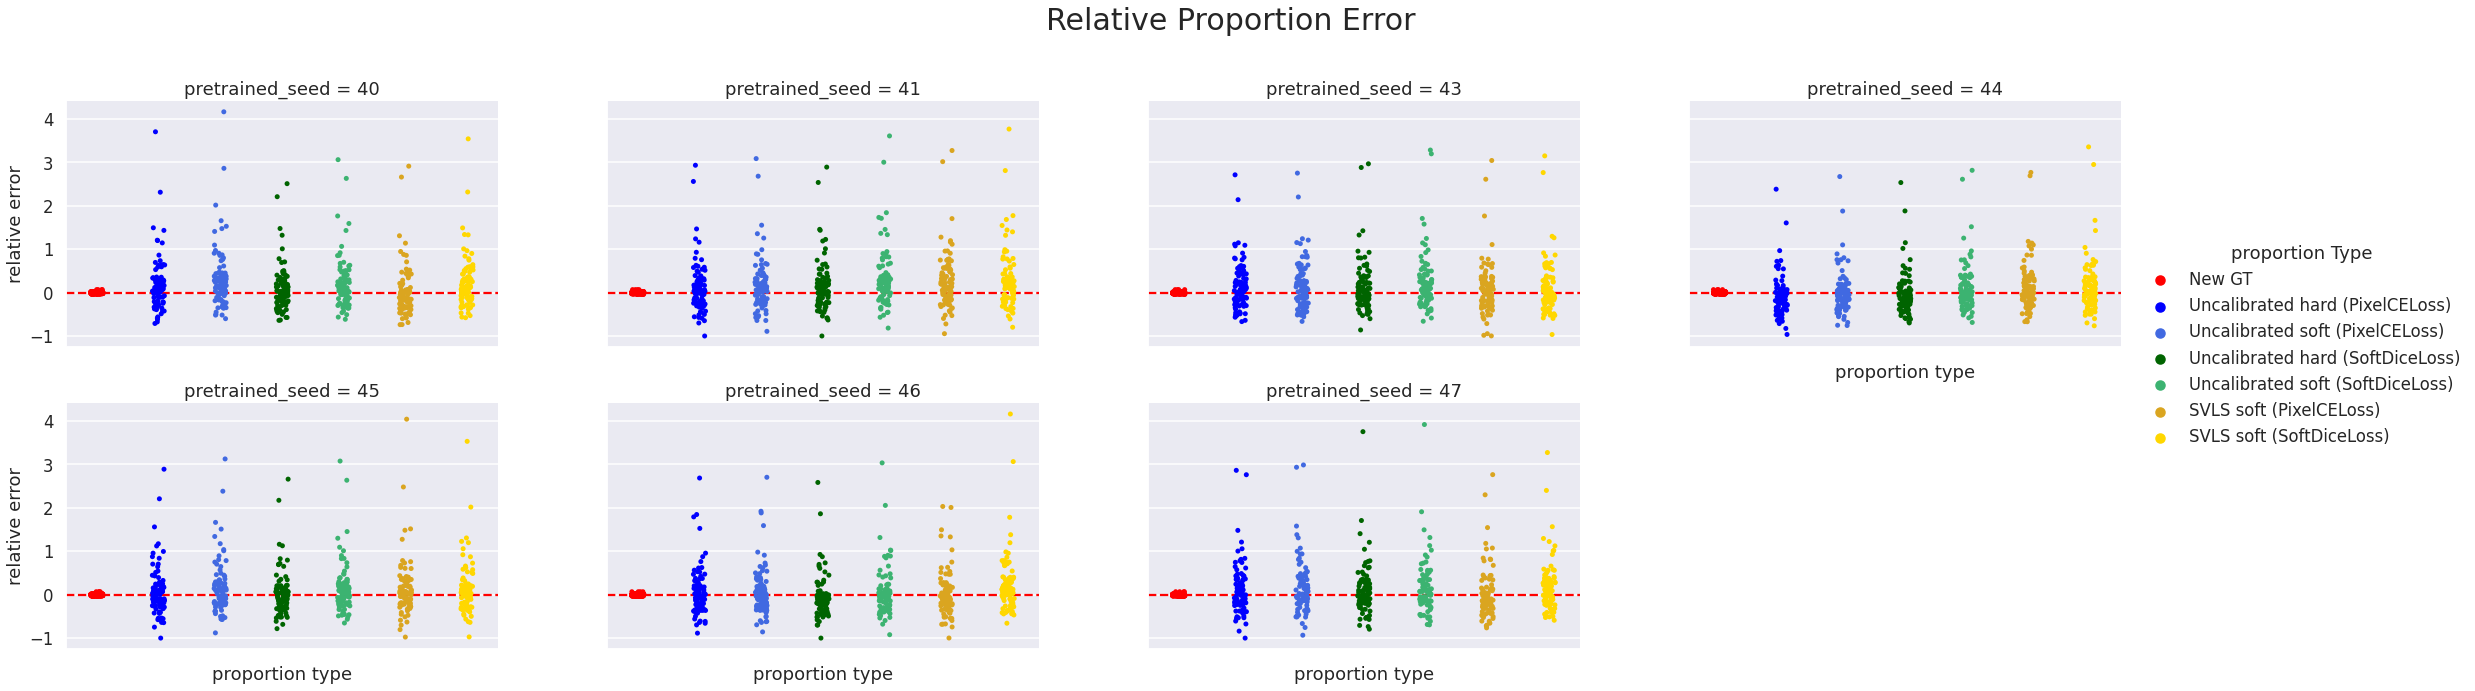

In [25]:
# Create the catplot
g = sns.catplot(
    data=melted_relative_df,      # Ensure you use the 'data' parameter correctly.
    x="proportion type",
    y="relative error",
    col="pretrained_seed",
    hue="proportion type",
    col_wrap=4,
    sharex=False,
    aspect=1.5,
    palette=custom_palette
)

# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0.0, ls='--', color='red')
    ax.set_xticklabels([])

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Relative Proportion Error', fontsize=30)

# Add a legend
g.add_legend(title='proportion Type')

# Show the plot
plt.show()

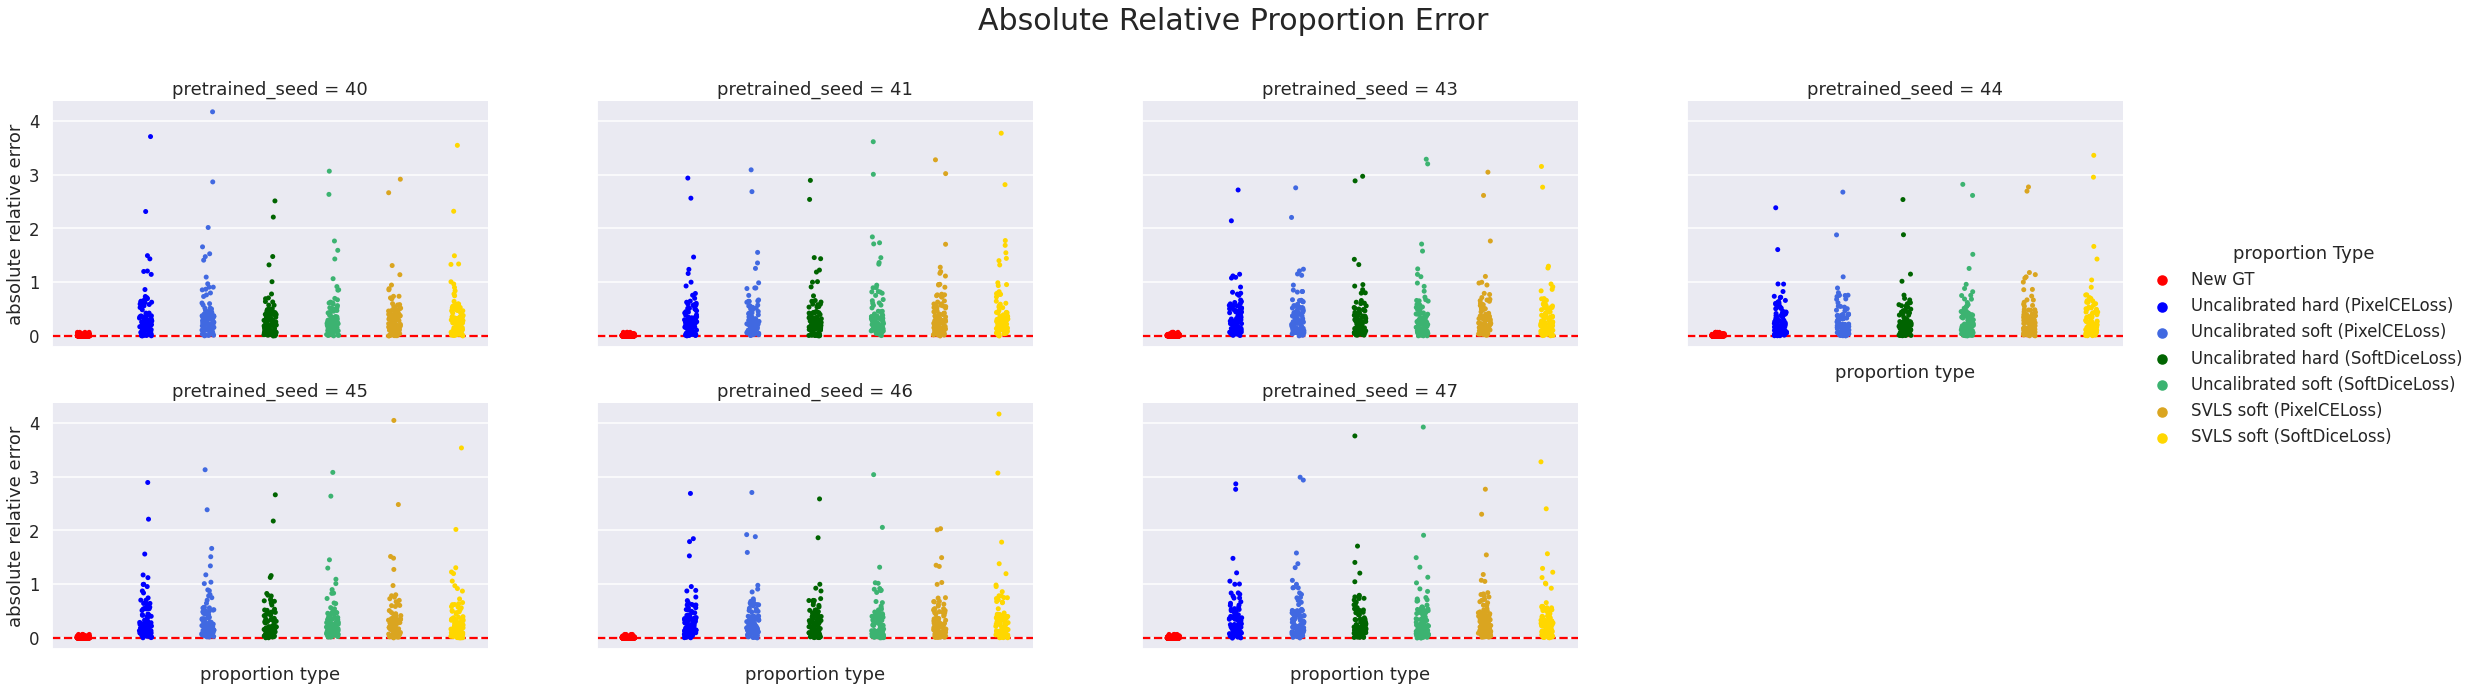

In [26]:
# Create the catplot
g = sns.catplot(
    data=melted_relative_df,      # Ensure you use the 'data' parameter correctly.
    x="proportion type",
    y="absolute relative error",
    col="pretrained_seed",
    hue="proportion type",
    col_wrap=4,
    sharex=False,
    aspect=1.5,
    palette=custom_palette
)

# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0.0, ls='--', color='red')
    ax.set_xticklabels([])

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Absolute Relative Proportion Error', fontsize=30)

# Add a legend
g.add_legend(title='proportion Type')

# Show the plot
plt.show()

In [27]:
# We want to calculate now the average (across seeds) of the the absolute error for each method.
# That means first averaging within each seed, then averaging across seeds.
# We group by the data_id and the proportion_type.
relative_per_seed = melted_relative_df.groupby(["pretrained_seed", "proportion type"]).agg(
    abs_relative_error=("absolute relative error", "mean"),
).reset_index()
# Rename abs_error to absolute error.
relative_per_seed = relative_per_seed.rename(columns={"abs_relative_error": "absolute relative error"})

In [28]:
# make a table with each row being the proportion type, and the column being the abs_error mean with standard deviation in another column.
method_relative_table = relative_per_seed.pivot_table(
    values="absolute relative error",
    index="proportion type",
    columns="pretrained_seed",
    aggfunc="mean",
)
# Average across the pretrained seeds to make an average column, and then make a stdv column.
method_relative_table['mean'] = method_relative_table.mean(axis=1)
method_relative_table['stdv'] = method_relative_table.std(axis=1)
# We can drop all other columns that aren't mean and stdv
method_relative_table = method_relative_table[['mean', 'stdv']]

In [29]:
method_relative_table.sort_values(by='mean')

pretrained_seed,mean,stdv
proportion type,,
New GT,0.011811,1.734723e-18
Uncalibrated hard (SoftDiceLoss),0.336867,2.066033e-02
Uncalibrated hard (PixelCELoss),0.372354,2.594303e-02
Uncalibrated soft (SoftDiceLoss),0.378057,3.994347e-02
SVLS soft (PixelCELoss),0.384447,2.923606e-02
SVLS soft (SoftDiceLoss),0.389935,3.012059e-02
Uncalibrated soft (PixelCELoss),0.395080,4.206180e-02


# Finally, we want to look at the Dice score and Image ECE of all three methods as we are arguing that Image ECE is what we should care about.

In [30]:
inference_df

,pred_hash,image_metric,metric_score,batch_idx,split,data_cfg_opt,label_idx,gt_proportion,data_id,gt_volume,...,filters,in_channels,out_channels,pred_label,pretrained_exp_root,pretrained_select_metric,_pretrained_class,joint_data_slice_id,method_name,loss_func
0,3200231835675764901,Dice,0.850000,0,val,split:val,-1,0.009850,subject_10233.bmp,162,...,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/06_27_24_...,val-dice_score,None,subject_10233.bmp_None,UNet (seed=40),SoftDiceLoss
1,3200231835675764901,HD95,2.236068,0,val,split:val,-1,0.009850,subject_10233.bmp,162,...,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/06_27_24_...,val-dice_score,None,subject_10233.bmp_None,UNet (seed=40),SoftDiceLoss
2,3200231835675764901,BoundaryIOU,0.660098,0,val,split:val,-1,0.009850,subject_10233.bmp,162,...,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/06_27_24_...,val-dice_score,None,subject_10233.bmp_None,UNet (seed=40),SoftDiceLoss
3,3200231835675764901,SoftVolumeError,47.738251,0,val,split:val,-1,0.009850,subject_10233.bmp,162,...,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/06_27_24_...,val-dice_score,None,subject_10233.bmp_None,UNet (seed=40),SoftDiceLoss
4,3200231835675764901,HardVolumeError,36.000000,0,val,split:val,-1,0.009850,subject_10233.bmp,162,...,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/06_27_24_...,val-dice_score,None,subject_10233.bmp_None,UNet (seed=40),SoftDiceLoss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34843,6255439610731333156,Dice Loss,0.187970,6,cal,split:cal,-1,0.011469,subject_10295.bmp,189,...,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/06_27_24_...,val-dice_score,None,subject_10295.bmp_None,UNet (seed=40),PixelCELoss
34844,-5675495527121235555,Dice Loss,0.098361,7,cal,split:cal,-1,0.011163,subject_10051.bmp,181,...,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/06_27_24_...,val-dice_score,None,subject_10051.bmp_None,UNet (seed=40),PixelCELoss
34845,-6330016476771143338,Dice Loss,0.232228,7,cal,split:cal,-1,0.014325,subject_10159.bmp,239,...,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/06_27_24_...,val-dice_score,None,subject_10159.bmp_None,UNet (seed=40),PixelCELoss
34846,-1228646943555335058,Dice Loss,0.470199,7,cal,split:cal,-1,0.008587,subject_10096.bmp,141,...,"(64, 64, 64, 64, 64)",1,1,0,/storage/vbutoi/scratch/ESE/training/06_27_24_...,val-dice_score,None,subject_10096.bmp_None,UNet (seed=40),PixelCELoss


In [31]:
# Get the relevant columns for looking at the Dice score and Image ECE
metric_cols = [
    "data_id",
    "loss_func",
    "pretrained_seed",
    "pretrained_exp_root",
    "split",
    "image_metric",
    "metric_score"
]
# Take these columns of the inference_df, drop other columns and delete duplicate rows.
metric_df = inference_df[metric_cols].drop_duplicates().reset_index(drop=True)
metric_df.augment(calibrator)
# Drop the 'pretrained_exp_root column
metric_df = metric_df.drop(columns=["pretrained_exp_root"])

In [32]:
def train_method(calibrator, loss_func):
    return calibrator + f" ({loss_func})"

metric_df.augment(train_method)

In [33]:
metric_df

,data_id,loss_func,pretrained_seed,split,image_metric,metric_score,calibrator,train_method
0,subject_10233.bmp,SoftDiceLoss,40,val,Dice,0.850000,SVLS,SVLS (SoftDiceLoss)
1,subject_10233.bmp,SoftDiceLoss,40,val,HD95,2.236068,SVLS,SVLS (SoftDiceLoss)
2,subject_10233.bmp,SoftDiceLoss,40,val,BoundaryIOU,0.660098,SVLS,SVLS (SoftDiceLoss)
3,subject_10233.bmp,SoftDiceLoss,40,val,SoftVolumeError,47.738251,SVLS,SVLS (SoftDiceLoss)
4,subject_10233.bmp,SoftDiceLoss,40,val,HardVolumeError,36.000000,SVLS,SVLS (SoftDiceLoss)
...,...,...,...,...,...,...,...,...
34843,subject_10295.bmp,PixelCELoss,40,cal,Dice Loss,0.187970,Uncalibrated,Uncalibrated (PixelCELoss)
34844,subject_10051.bmp,PixelCELoss,40,cal,Dice Loss,0.098361,Uncalibrated,Uncalibrated (PixelCELoss)
34845,subject_10159.bmp,PixelCELoss,40,cal,Dice Loss,0.232228,Uncalibrated,Uncalibrated (PixelCELoss)
34846,subject_10096.bmp,PixelCELoss,40,cal,Dice Loss,0.470199,Uncalibrated,Uncalibrated (PixelCELoss)


In [34]:
# Groupby the pretrained_seed and image_metrics, and calibrator, and take the mean of the metric_score.
metric_per_seed = metric_df.groupby(["pretrained_seed", "loss_func", "image_metric", "train_method"]).agg(
    metric_score=("metric_score", "mean"),
).reset_index()

In [35]:
# Finally, we want to change the order that the methods appear in.
metric_per_seed['train_method'] = metric_per_seed['train_method'].astype('category')
metric_per_seed['train_method'] = metric_per_seed['train_method'].cat.reorder_categories([
    'Uncalibrated (PixelCELoss)',
    'Uncalibrated (SoftDiceLoss)',
    'SVLS (PixelCELoss)',
    'SVLS (SoftDiceLoss)',
])

In [36]:
result = metric_per_seed.groupby(['train_method', 'image_metric']).agg(
    mean_metric_score=('metric_score', 'mean'),
    std_metric_score=('metric_score', 'std')
).reset_index()

# Pivot the table to have one row for each train_method
result = result.pivot(
    index='train_method', 
    columns='image_metric', 
    values=[
        'mean_metric_score', 
        'std_metric_score'
    ]
)

# Flatten the column multi-index
result.columns = ['_'.join(col).strip() for col in result.columns.values]
result = result.reset_index()

In [37]:
result

,train_method,mean_metric_score_BoundaryIOU,mean_metric_score_Dice,mean_metric_score_Dice Loss,mean_metric_score_HD95,mean_metric_score_HardVolumeError,mean_metric_score_Image_CW-ECE,mean_metric_score_Image_ECE,mean_metric_score_Image_ECW-ECE,mean_metric_score_Image_Edge-ECE,...,std_metric_score_Dice Loss,std_metric_score_HD95,std_metric_score_HardVolumeError,std_metric_score_Image_CW-ECE,std_metric_score_Image_ECE,std_metric_score_Image_ECW-ECE,std_metric_score_Image_Edge-ECE,std_metric_score_Image_Uniform-CW-ECE,std_metric_score_Image_Uniform-ECW-ECE,std_metric_score_SoftVolumeError
0,Uncalibrated (PixelCELoss),0.545549,0.746302,0.253698,3.741219,-14.512363,0.004370,0.004370,0.202186,0.266604,...,0.006948,0.391824,11.412492,0.000291,0.000291,0.021139,0.033684,0.000291,0.021139,13.831549
1,Uncalibrated (SoftDiceLoss),0.486589,0.660113,0.339887,13.333126,2009.673077,0.127308,0.127308,0.212294,0.297994,...,0.258124,27.068026,5735.190104,0.348092,0.348092,0.038862,0.098164,0.348092,0.038862,5727.929851
2,SVLS (PixelCELoss),0.540693,0.739747,0.260253,3.948909,-17.782967,0.004452,0.004452,0.202070,0.257459,...,0.012025,0.779179,15.838692,0.000264,0.000264,0.020096,0.020883,0.000264,0.020096,20.767667
3,SVLS (SoftDiceLoss),0.550966,0.751065,0.248935,3.761931,-10.858516,0.004253,0.004253,0.195667,0.261224,...,0.004744,0.244590,8.292292,0.000156,0.000156,0.010186,0.013890,0.000156,0.010186,9.938010


In [38]:
# Get all the of the columns that are 'calibrator' and have 'Dice_Loss' in them
dice_cols = [col for col in result.columns if 'Dice Loss' in col or 'train_method' in col]
dice_result = result[dice_cols]

In [39]:
dice_result.sort_values(by='mean_metric_score_Dice Loss')

,train_method,mean_metric_score_Dice Loss,std_metric_score_Dice Loss
3,SVLS (SoftDiceLoss),0.248935,0.004744
0,Uncalibrated (PixelCELoss),0.253698,0.006948
2,SVLS (PixelCELoss),0.260253,0.012025
1,Uncalibrated (SoftDiceLoss),0.339887,0.258124


In [40]:
# Get all the of the columns that are 'calibrator' and have 'Image_ECE' in them
image_ece_cols = [col for col in result.columns if 'Image_ECE' in col or 'train_method' in col]
ece_result = result[image_ece_cols]

In [41]:
ece_result.sort_values(by='mean_metric_score_Image_ECE')

,train_method,mean_metric_score_Image_ECE,std_metric_score_Image_ECE
3,SVLS (SoftDiceLoss),0.004253,0.000156
0,Uncalibrated (PixelCELoss),0.004370,0.000291
2,SVLS (PixelCELoss),0.004452,0.000264
1,Uncalibrated (SoftDiceLoss),0.127308,0.348092
